In [1]:
####################################################
# pyFIT3D Emission lines system simulation example
# --------------------------------------------------
# In this example we build the output files using
# pyFIT3D.common.gas_tools emission_lines functions.
####################################################
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as copy
from contextlib import redirect_stdout

from pyFIT3D.common.constants import _EL_MODELS, __n_models_params__
from pyFIT3D.common.gas_tools import fit_elines_main, ConfigEmissionModel
from pyFIT3D.common.io import trim_waves, read_spectra, get_data_from_fits, get_wave_from_header
from pyFIT3D.common.gas_tools import output_emission_lines_parameters, output_emission_lines_spectra
from pyFIT3D.common.gas_tools import create_emission_lines_parameters, append_emission_lines_parameters

# output original and perturbed  configuration files foreach 
save_configs = True

# RND, LM or BOTH
run_mode = 'BOTH'

# Noise level in log10
l_max_noise = 1
l_min_noise = -2

# number of simulations
nsim = 30

# will prefix output files.
prefix_user = 'sim'
prefix = f'{prefix_user}_{run_mode}_{nsim}'

# guess, max and min velocity [km/s]
min_vel_sys = 5500  
max_vel_sys = 6500
v0_guess = 6000
# and dispersion (sigma in \AA)
min_sigma = 2.5
max_sigma = 6.5
sigma_guess = 2.65

# pyFIT3D.common.gas_tools fit_elines_main() arguments:
redefine_max = 1
n_MC = 20
n_loops = 4
scale_ini = 0.15

In [2]:
def build_NIIHa_config(Ha_flux, NII_flux, sigma_boundaries, v0_boundaries, cont_boundaries=None):
    cf = ConfigEmissionModel(filename=None, chi_goal=0.5, chi_step=0.1)

    i_wave = _EL_MODELS['eline']['central_wavelength']
    i_flux = _EL_MODELS['eline']['flux']
    i_sigma = _EL_MODELS['eline']['sigma']
    i_v0 = _EL_MODELS['eline']['v0']

    sigma_guess = sigma_boundaries[0] + np.random.rand()*(sigma_boundaries[1] - sigma_boundaries[0])
    # adjust boundaries to be inside search range
    sigma_boundaries = np.array(sigma_boundaries)*np.array([0.9, 1.1])

    v0_guess = v0_boundaries[0] + np.random.rand()*(v0_boundaries[1] - v0_boundaries[0])
    # adjust boundaries to be inside search range
    v0_boundaries = np.array(v0_boundaries)*np.array([0.98, 1.02])

    # Ha
    guess = np.zeros((__n_models_params__), dtype=np.float)
    pars_0 = np.zeros((__n_models_params__), dtype=np.float)
    pars_1 = np.zeros((__n_models_params__), dtype=np.float)
    links = -1*np.ones((__n_models_params__), dtype=np.int)
    to_fit = np.zeros((__n_models_params__), dtype=np.bool)
    guess[i_wave] = 6562.68
    guess[i_flux] = Ha_flux
    guess[i_sigma] = sigma_guess
    guess[i_v0] = v0_guess
    pars_0[i_flux] = -0.001
    pars_1[i_flux] = 1e10
    pars_0[i_sigma] = 2
    pars_1[i_sigma] = 7
    pars_0[i_v0] = 5500
    pars_1[i_v0] = 6500
    cf.add_model(
        model_type='eline',
        guess=guess, to_fit=to_fit, pars_0=pars_0, pars_1=pars_1, links=links
    )

    #[NII]6583
    guess = np.zeros((__n_models_params__), dtype=np.float)
    pars_0 = np.zeros((__n_models_params__), dtype=np.float)
    pars_1 = np.zeros((__n_models_params__), dtype=np.float)
    links = -1*np.ones((__n_models_params__), dtype=np.int)
    to_fit = np.zeros((__n_models_params__), dtype=np.bool)
    guess[i_wave] = 6583.41
    guess[i_flux] = NII_flux
    guess[i_sigma] = sigma_guess
    guess[i_v0] = v0_guess
    pars_0[i_flux] = -0.001
    pars_1[i_flux] = 1e10
    # link sigma and v0 to Ha
    links[i_sigma] = 1
    links[i_v0] = 1
    cf.add_model(
        model_type='eline',
        guess=guess, to_fit=to_fit, pars_0=pars_0, pars_1=pars_1, links=links
    )

    #[NII]6548
    guess = np.zeros((__n_models_params__), dtype=np.float)
    pars_0 = np.zeros((__n_models_params__), dtype=np.float)
    pars_1 = np.zeros((__n_models_params__), dtype=np.float)
    links = -1*np.ones((__n_models_params__), dtype=np.int)
    to_fit = np.zeros((__n_models_params__), dtype=np.bool)
    guess[i_wave] = 6548.08
    guess[i_flux] = NII_flux*0.33
    guess[i_sigma] = sigma_guess
    guess[i_v0] = v0_guess
    pars_0[i_flux] = 0.333
    pars_1[i_flux] = 1
    # link flux to [NII]6584
    links[i_flux] = 2
    # link sigma and v0 to Ha
    links[i_sigma] = 1
    links[i_v0] = 1
    cf.add_model(
        model_type='eline',
        guess=guess, to_fit=to_fit, pars_0=pars_0, pars_1=pars_1, links=links
    )

    if cont_boundaries is not None:
        cont_guess = cont_boundaries[0] + np.random.rand()*(cont_boundaries[1] - cont_boundaries[0])
        # adjust boundaries to be inside search range
        cont_boundaries = np.array(cont_boundaries)*np.array([0.9, 1.1])
        i_cont = _EL_MODELS['poly1d']['cont']

        guess = np.zeros((__n_models_params__), dtype=np.float)
        pars_0 = np.zeros((__n_models_params__), dtype=np.float)
        pars_1 = np.zeros((__n_models_params__), dtype=np.float)
        links = -1*np.ones((__n_models_params__), dtype=np.int)
        to_fit = np.zeros((__n_models_params__), dtype=np.bool)
        guess[i_cont] = cont_guess
        pars_0[i_cont] = -1e13
        pars_1[i_cont] = 1e13
        cf.add_model(
            model_type='poly1d',
            guess=guess, to_fit=to_fit, pars_0=pars_0, pars_1=pars_1, links=links
        )

    return cf

def build_fit_config(cf_fix, flux=None, sigma=None, v0=None, cont=None):
    cf = copy(cf_fix)
    cf.n_free_param = 0
    for i in range(cf.n_models):
        if cf.model_types[i] == 'eline':
            i_flux = _EL_MODELS['eline']['flux']
            i_sigma = _EL_MODELS['eline']['sigma']
            i_v0 = _EL_MODELS['eline']['v0']
            cf.to_fit[i][i_flux] = True
            cf.to_fit[i][i_sigma] = True
            cf.to_fit[i][i_v0] = True
            if flux is not None:
                cf.guess[i][i_flux] = flux
            if sigma is not None:
                cf.guess[i][i_sigma] = sigma
            if v0 is not None:
                cf.guess[i][i_v0] = v0
        elif cf.model_types[i] == 'poly1d':
            i_cont = _EL_MODELS['poly1d']['cont']
            cf.to_fit[i][i_cont] = True
            if cont is not None:
                cf.guess[i][i_cont] = cont
        cf.n_free_param += (cf.to_fit[i] & (cf.links[i] == -1)).sum()
    cf._correct_guess()
    cf.boundaries = (
        cf.vectorize_pars(cf.pars_0),
        cf.vectorize_pars(cf.pars_1)
    )
    return cf

In [3]:
# models: Ha + [NII]6583 + [NII]6548 + continuum config
_tmp_cf = build_NIIHa_config(
    Ha_flux=100, NII_flux=66,
    sigma_boundaries=[sigma_guess, sigma_guess],
    v0_boundaries=[v0_guess, v0_guess]
)

# RUN SIMULATION

In [4]:
# start parameters structure
in_output_el_models = create_emission_lines_parameters(_tmp_cf, shape=(nsim))
output_el_models = create_emission_lines_parameters(_tmp_cf, shape=(nsim))

guess_cf = build_fit_config(_tmp_cf, sigma=sigma_guess, v0=v0_guess)
if save_configs:
    guess_cf.print(filename=f'guess.config')
    
# input spectrum with all zeros...
wave__w = 3749. + 2*np.arange(1877)
flux__w = np.zeros_like(wave__w)
eflux__w = np.zeros_like(wave__w)
sel__w = trim_waves(wave__w, [6500, 7000])

noise__s = np.zeros((nsim))

org_wave__w = wave__w[sel__w]
org_flux__w = flux__w[sel__w]
org_eflux__w = eflux__w[sel__w]

nw = org_wave__w.size
in_org__sw = np.zeros((nsim, nw))
in_mod__sw = np.zeros((nsim, nw))
in_res__sw = np.zeros((nsim, nw))
org__sw = np.zeros((nsim, nw))
mod__sw = np.zeros((nsim, nw))
res__sw = np.zeros((nsim, nw))

with redirect_stdout(None):
    for i in range(nsim):
        ##### GENERATE INPUT MODEL #####
        cf_nonpert = build_NIIHa_config(
            Ha_flux=100, NII_flux=66, 
            sigma_boundaries=[min_sigma, max_sigma],
            v0_boundaries=[min_vel_sys, max_vel_sys]
        )

        if save_configs:
            cf_nonpert.print(filename=f'nonpert.{i}.config')
        EL_nonpert = fit_elines_main(
            wavelength=org_wave__w, flux=org_flux__w, sigma_flux=org_eflux__w,
            config=cf_nonpert, redefine_max=1, n_MC=3, n_loops=5, plot=0, 
            run_mode='RND', check_stats=False,
        )    
        in_org__sw[i] = EL_nonpert.flux
        in_mod__sw[i] = EL_nonpert.model
        in_res__sw[i] = EL_nonpert.flux - EL_nonpert.model
        append_emission_lines_parameters(EL_nonpert, in_output_el_models, i)

        ##### ADD NOISE TO INPUT MODEL #####    
        l_noise = l_min_noise + (l_max_noise - l_min_noise)*np.random.rand()
        noise = 10**l_noise
        rnd__w = np.random.rand(EL_nonpert.wavelength.size) - 0.5
        perturbed_flux__w = EL_nonpert.model + noise*rnd__w
        error__w = np.sqrt(np.abs(EL_nonpert.model + 0.5*noise**2))
        noise__s[i] = noise

        ##### FIT PERTURBED MODEL #####
        EL = fit_elines_main(
            wavelength=EL_nonpert.wavelength, flux=perturbed_flux__w, sigma_flux=error__w,
            config=copy(guess_cf), redefine_max=redefine_max, n_MC=n_MC, n_loops=n_loops, scale_ini=scale_ini,
            plot=0, run_mode=run_mode, check_stats=True, fine_search=True,
        )
        org__sw[i] = EL.flux
        mod__sw[i] = EL.model
        res__sw[i] = EL.flux - EL.model
        append_emission_lines_parameters(EL, output_el_models, i)

    ##### OUTPUT SPECTRA AND PARAMETERS #####
    in_output_el_spectra = np.array([in_org__sw, in_mod__sw, in_res__sw])
    output_el_spectra = np.array([org__sw, mod__sw, res__sw])
    output_emission_lines_spectra(org_wave__w, in_output_el_spectra, None, f'{prefix}_input', wave_axis=1)
    output_emission_lines_parameters(f'{prefix}_input', guess_cf, in_output_el_models)
    output_emission_lines_spectra(org_wave__w, output_el_spectra, None, prefix, wave_axis=1)
    output_emission_lines_parameters(prefix, guess_cf, output_el_models)

OUT_CONFIG=guess.config


# Plot examples

In [5]:
in_flux_Ha__s = get_data_from_fits(f'{prefix}_input_flux_00.fits')
in_sigma_Ha__s = get_data_from_fits(f'{prefix}_input_sigma_00.fits')
in_vel_Ha__s = get_data_from_fits(f'{prefix}_input_vel_00.fits')
sigma_Ha__s = get_data_from_fits(f'{prefix}_sigma_00.fits')
vel_Ha__s = get_data_from_fits(f'{prefix}_vel_00.fits')
flux_Ha__s = get_data_from_fits(f'{prefix}_flux_00.fits')
l_SN_Ha__s = np.log10(in_flux_Ha__s/(in_sigma_Ha__s*(2*np.pi)**0.5)/noise__s)

delta_flux_Ha__s = flux_Ha__s - in_flux_Ha__s
delta_flux_Ha__s /= in_flux_Ha__s

Text(0.5, 1.0, 'Ha flux')

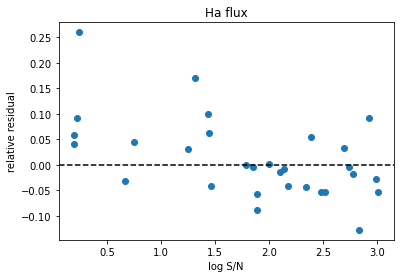

In [6]:
plt.scatter(l_SN_Ha__s, delta_flux_Ha__s)
plt.axhline(0, ls='--', color='k')
plt.xlabel('log S/N')
plt.ylabel('relative residual')
plt.title('Ha flux')

input S/N: 17.63 A
input flux: 100.00 A - output sigma: 103.00 A
input sigma: 2.52 A - output sigma: 2.50 A
input vel: 5539.75 A - output vel: 5530.67 A


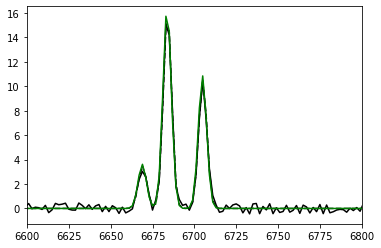

In [7]:
input_spec__sw, h = get_data_from_fits(f'{prefix}_input_mod.fits', header=True)
input_pert_spec__sw, h = get_data_from_fits(f'{prefix}_org.fits', header=True)
mod_spec__sw, h = get_data_from_fits(f'{prefix}_mod.fits', header=True)
isim = 1
_wl = get_wave_from_header(h, 1)
plt.plot(_wl, input_spec__sw[isim], 'k--')
plt.plot(_wl, input_pert_spec__sw[isim], 'k-')
plt.plot(_wl, mod_spec__sw[isim], 'g-')
plt.xlim(6600, 6800)
print(f'input S/N: {10**l_SN_Ha__s[isim]:.2f} A')
print(f'input flux: {in_flux_Ha__s[isim]:.2f} A - output sigma: {flux_Ha__s[isim]:.2f} A')
print(f'input sigma: {in_sigma_Ha__s[isim]:.2f} A - output sigma: {sigma_Ha__s[isim]:.2f} A')
print(f'input vel: {in_vel_Ha__s[isim]:.2f} A - output vel: {vel_Ha__s[isim]:.2f} A')